# Spotify Churn Analysis & Prediction


### 1. Import Libraries


In [75]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### 2. Load Data


In [76]:
df = pd.read_csv("spotify_churn_dataset.csv")

In [77]:
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


### 3. Exploratory Data Analysis

In [56]:
df.isna().sum()

user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64

In [57]:
df.duplicated().sum()

0

In [58]:
df.describe()

,user_id,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4000.50000,37.662125,154.068250,50.127250,0.300127,6.943875,0.747750,0.258875
std,2309.54541,12.740359,84.015596,28.449762,0.173594,13.617953,0.434331,0.438044
min,1.00000,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.75000,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000,0.000000
50%,4000.50000,38.000000,154.000000,50.000000,0.300000,0.000000,1.000000,0.000000
75%,6000.25000,49.000000,227.000000,75.000000,0.450000,5.000000,1.000000,1.000000
max,8000.00000,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000,1.000000


In [59]:
df.shape

(8000, 12)

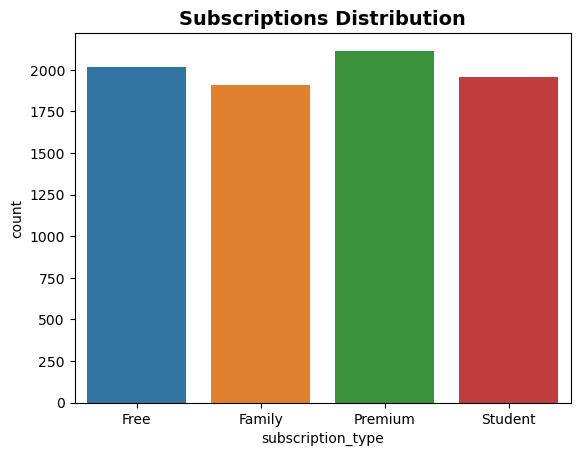

In [60]:
sns.countplot(data=df, x='subscription_type',hue="subscription_type")
plt.title('Subscriptions Distribution', fontsize=14, fontweight='bold')
plt.show()

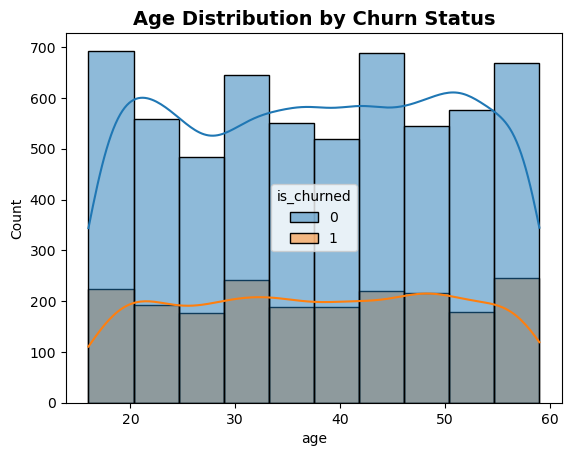

In [61]:
sns.histplot(df, x="age", hue="is_churned", bins=10, kde=True)
plt.title("Age Distribution by Churn Status", fontsize=14, fontweight="bold")
plt.show()

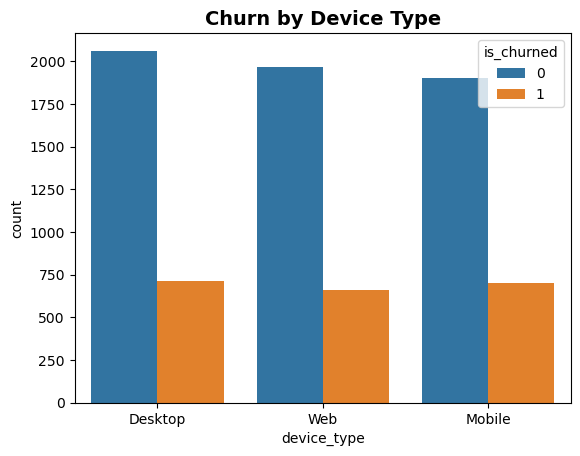

In [62]:
sns.countplot(data=df, x="device_type", hue="is_churned")
plt.title("Churn by Device Type", fontsize=14, fontweight="bold")
plt.show()

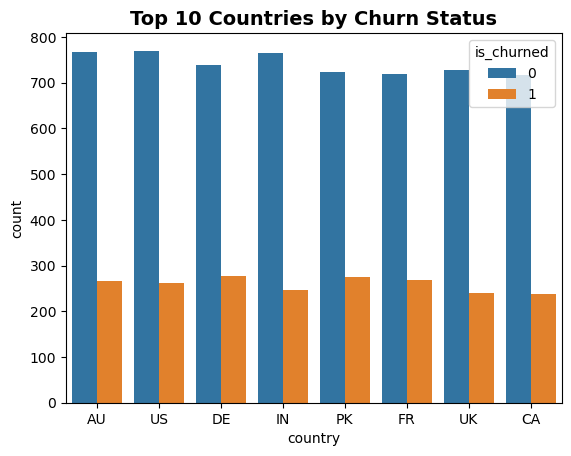

In [63]:
top_countries = df['country'].value_counts().head(10).index
sns.countplot(data=df[df['country'].isin(top_countries)], x="country", hue="is_churned",order=top_countries)
plt.title("Top 10 Countries by Churn Status", fontsize=14, fontweight="bold")
plt.show()

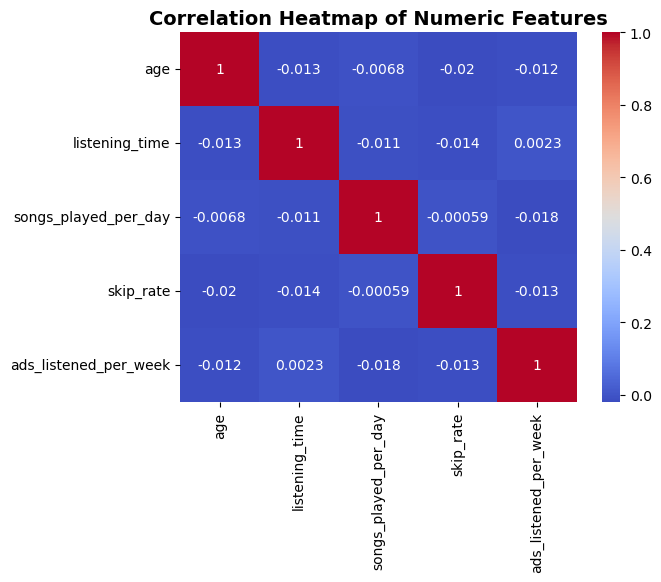

In [64]:
num_cols = ['age','listening_time','songs_played_per_day','skip_rate','ads_listened_per_week']
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features", fontsize=14, fontweight="bold")
plt.show()

### 4. Machine Learning


In [65]:
X = df.drop(['is_churned'],axis=1)
y = df['is_churned']

In [66]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','category']).columns

In [67]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ],
    remainder='drop'
)


In [68]:
models = {
    "KNN": (KNeighborsClassifier(), {"clf__n_neighbors": [3,5,7,9,11]}),
    "DecisionTree": (DecisionTreeClassifier(random_state=1), {"clf__max_depth": [3,5,7,10]}),
    "RandomForest": (RandomForestClassifier(random_state=1), {"clf__n_estimators": [50,100,200]}),
    "LogisticRegression": (LogisticRegression(max_iter=1000, random_state=1), {"clf__C": [0.1,1,10]})
}

In [69]:
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [70]:
results = {}

for name, (model, params) in models.items():
    print(f"\n===== {name} =====")
    
    pipe = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', model)
    ])
    
    grid = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
    grid.fit(X_train, y_train)
    
    print("Best Params:", grid.best_params_)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    
    results[name] = {
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Report": classification_report(y_test, y_pred, output_dict=True)
    }


===== KNN =====
Best Params: {'clf__n_neighbors': 3}
Accuracy: 0.659375
              precision    recall  f1-score   support

           0       0.75      0.83      0.78      1198
           1       0.24      0.16      0.19       402

    accuracy                           0.66      1600
   macro avg       0.49      0.49      0.49      1600
weighted avg       0.62      0.66      0.64      1600


===== DecisionTree =====
Best Params: {'clf__max_depth': 10}
Accuracy: 0.711875
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1198
           1       0.23      0.06      0.10       402

    accuracy                           0.71      1600
   macro avg       0.49      0.50      0.46      1600
weighted avg       0.62      0.71      0.65      1600


===== RandomForest =====
Best Params: {'clf__n_estimators': 50}
Accuracy: 0.74375
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1198


c:\Users\aabx9\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aabx9\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aabx9\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aabx9\anaconda3\Lib\site-packag

### 5. Summary of Model Performance


In [71]:
summary = pd.DataFrame({
    model: {"Accuracy": res["Accuracy"]} 
    for model, res in results.items()
}).T
print(summary)


                    Accuracy
KNN                 0.659375
DecisionTree        0.711875
RandomForest        0.743750
LogisticRegression  0.748750
